In [3]:
#Importing packages and reading data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson
from astropy.io import ascii
from sklearn.linear_model import LinearRegression
import arviz as az
import pymc as pm

df = pd.read_csv("Cepheids_DATA_errMVerrP.csv")
df

MV  MV_err  LogP  LogP_err
0   -3.47    0.09  0.58      0.02
1   -3.15    0.10  0.76      0.02
2   -3.33    0.09  0.70      0.07
3   -5.41    0.08  1.48      0.02
4   -3.70    0.09  0.70      0.02
..    ...     ...   ...       ...
198 -3.59    0.09  0.82      0.07
199 -3.66    0.09  0.76      0.02
200  0.25    0.46  0.17      0.07
201 -3.46    0.09  0.99      0.02
202 -4.86    0.08  1.14      0.07

[203 rows x 4 columns]

array([[<Axes: title={'center': 'MV'}>]], dtype=object)

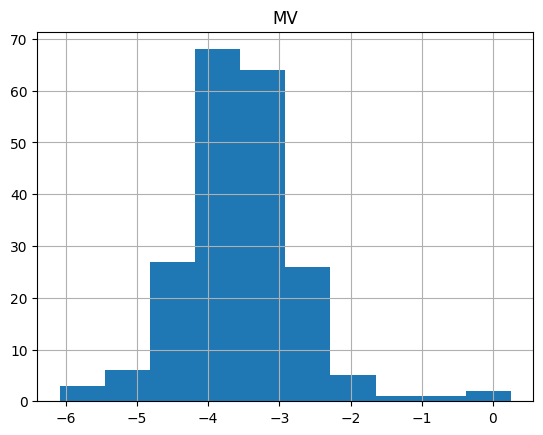

In [4]:
#Visual Inspection
df.hist('MV')


array([[<Axes: title={'center': 'LogP'}>]], dtype=object)

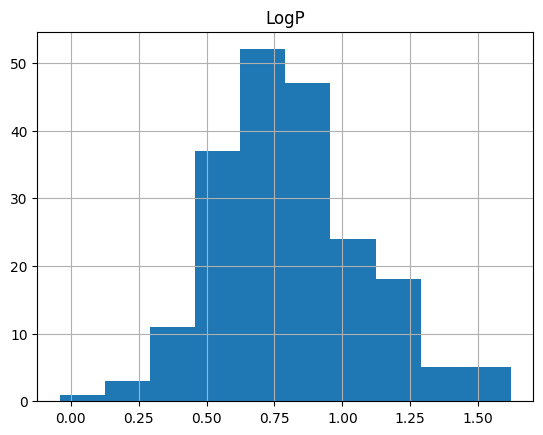

In [6]:
df.hist("LogP")

array([[<Axes: title={'center': 'MV_err'}>]], dtype=object)

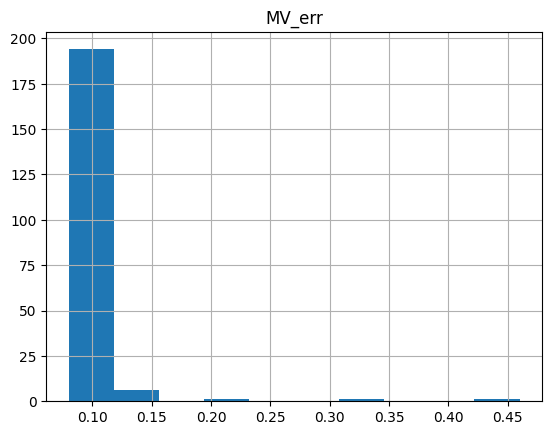

In [7]:
df.hist('MV_err')

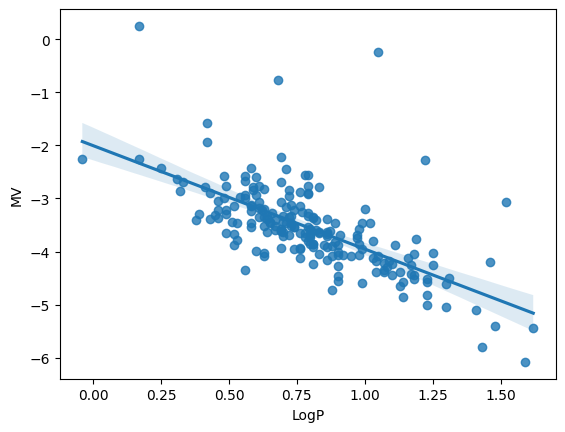

In [11]:
import seaborn as sns

regression = sns.regplot(data = df, x = df['LogP'], y = df['MV'])



Running on PyMC v5.9.0


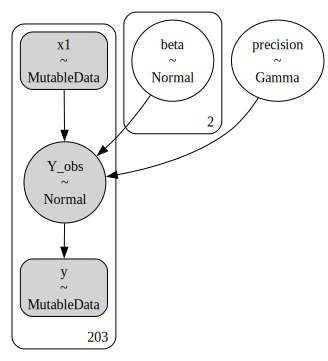

In [23]:
#linear model without error

from pymc import Model, Normal, Gamma, model_to_graphviz
# The following code implements the model in PyMC:

basic_model = Model() #<1>
with basic_model as basic: #<2>
    y=pm.MutableData(name='y',value =df['MV']) #<3> -- UNOBSERVED RV
    x1=pm.MutableData(name='x1',value =df['LogP'])
    # Priors for unknown model parameters -- PRIOR DISTRIBUTIONS
    beta = Normal('beta', mu=0, tau=1./10, shape=2) #<4>
    precision = Gamma('precision', alpha=1, beta=1)
    # Expected value of outcome
    mu =beta[0] + beta[1]*x1 
    # Likelihood (sampling distribution) of observations-- OBSERVED RV
    Y_obs = Normal('Y_obs', mu=mu, tau=precision, observed=y)
    
model_to_graphviz(basic)

In [26]:
# Draw sample
from pymc import find_MAP

%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

print(f"Running on PyMC v{pm.__version__}")
with basic:
    start = find_MAP() 
    # draw 2000 posterior samples
    trace = pm.sample(cores=4, chains=6, return_inferencedata=True)
trace

Running on PyMC v5.9.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (6 chains in 4 jobs)
NUTS: [beta, precision]


Sampling 6 chains for 1_000 tune and 1_000 draw iterations (6_000 + 6_000 draws total) took 2 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [27]:
# first 5 values for lambda from 4 chains
trace.posterior["precision"].sel(draw=slice(0, 4))

<xarray.DataArray 'precision' (chain: 6, draw: 5)>
array([[2.42221749, 2.67305351, 2.54446782, 2.82173005, 2.71846485],
       [3.00720794, 3.05298878, 2.93576198, 2.9285573 , 2.47092823],
       [2.283247  , 2.21541124, 3.20936999, 3.17996639, 2.51564471],
       [2.81693581, 2.84995931, 2.81189855, 2.98903486, 2.12352468],
       [2.64757428, 2.9854446 , 2.85644776, 2.71078551, 2.8967632 ],
       [2.60584864, 2.59899129, 2.58381847, 2.72770703, 2.27442115]])
Coordinates:
  * chain    (chain) int64 0 1 2 3 4 5
  * draw     (draw) int64 0 1 2 3 4

In [28]:
posterior = trace.posterior
posterior

<xarray.Dataset>
Dimensions:     (chain: 6, draw: 1000, beta_dim_0: 2)
Coordinates:
  * chain       (chain) int64 0 1 2 3 4 5
  * draw        (draw) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * beta_dim_0  (beta_dim_0) int64 0 1
Data variables:
    beta        (chain, draw, beta_dim_0) float64 -2.058 -1.928 ... -1.729
    precision   (chain, draw) float64 2.422 2.673 2.544 ... 2.551 2.823 2.85
Attributes:
    created_at:                 2023-11-01T15:23:47.681347
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.9.0
    sampling_time:              1.9611270427703857
    tuning_steps:               1000

array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'precision'}>,
        <Axes: title={'center': 'precision'}>]], dtype=object)

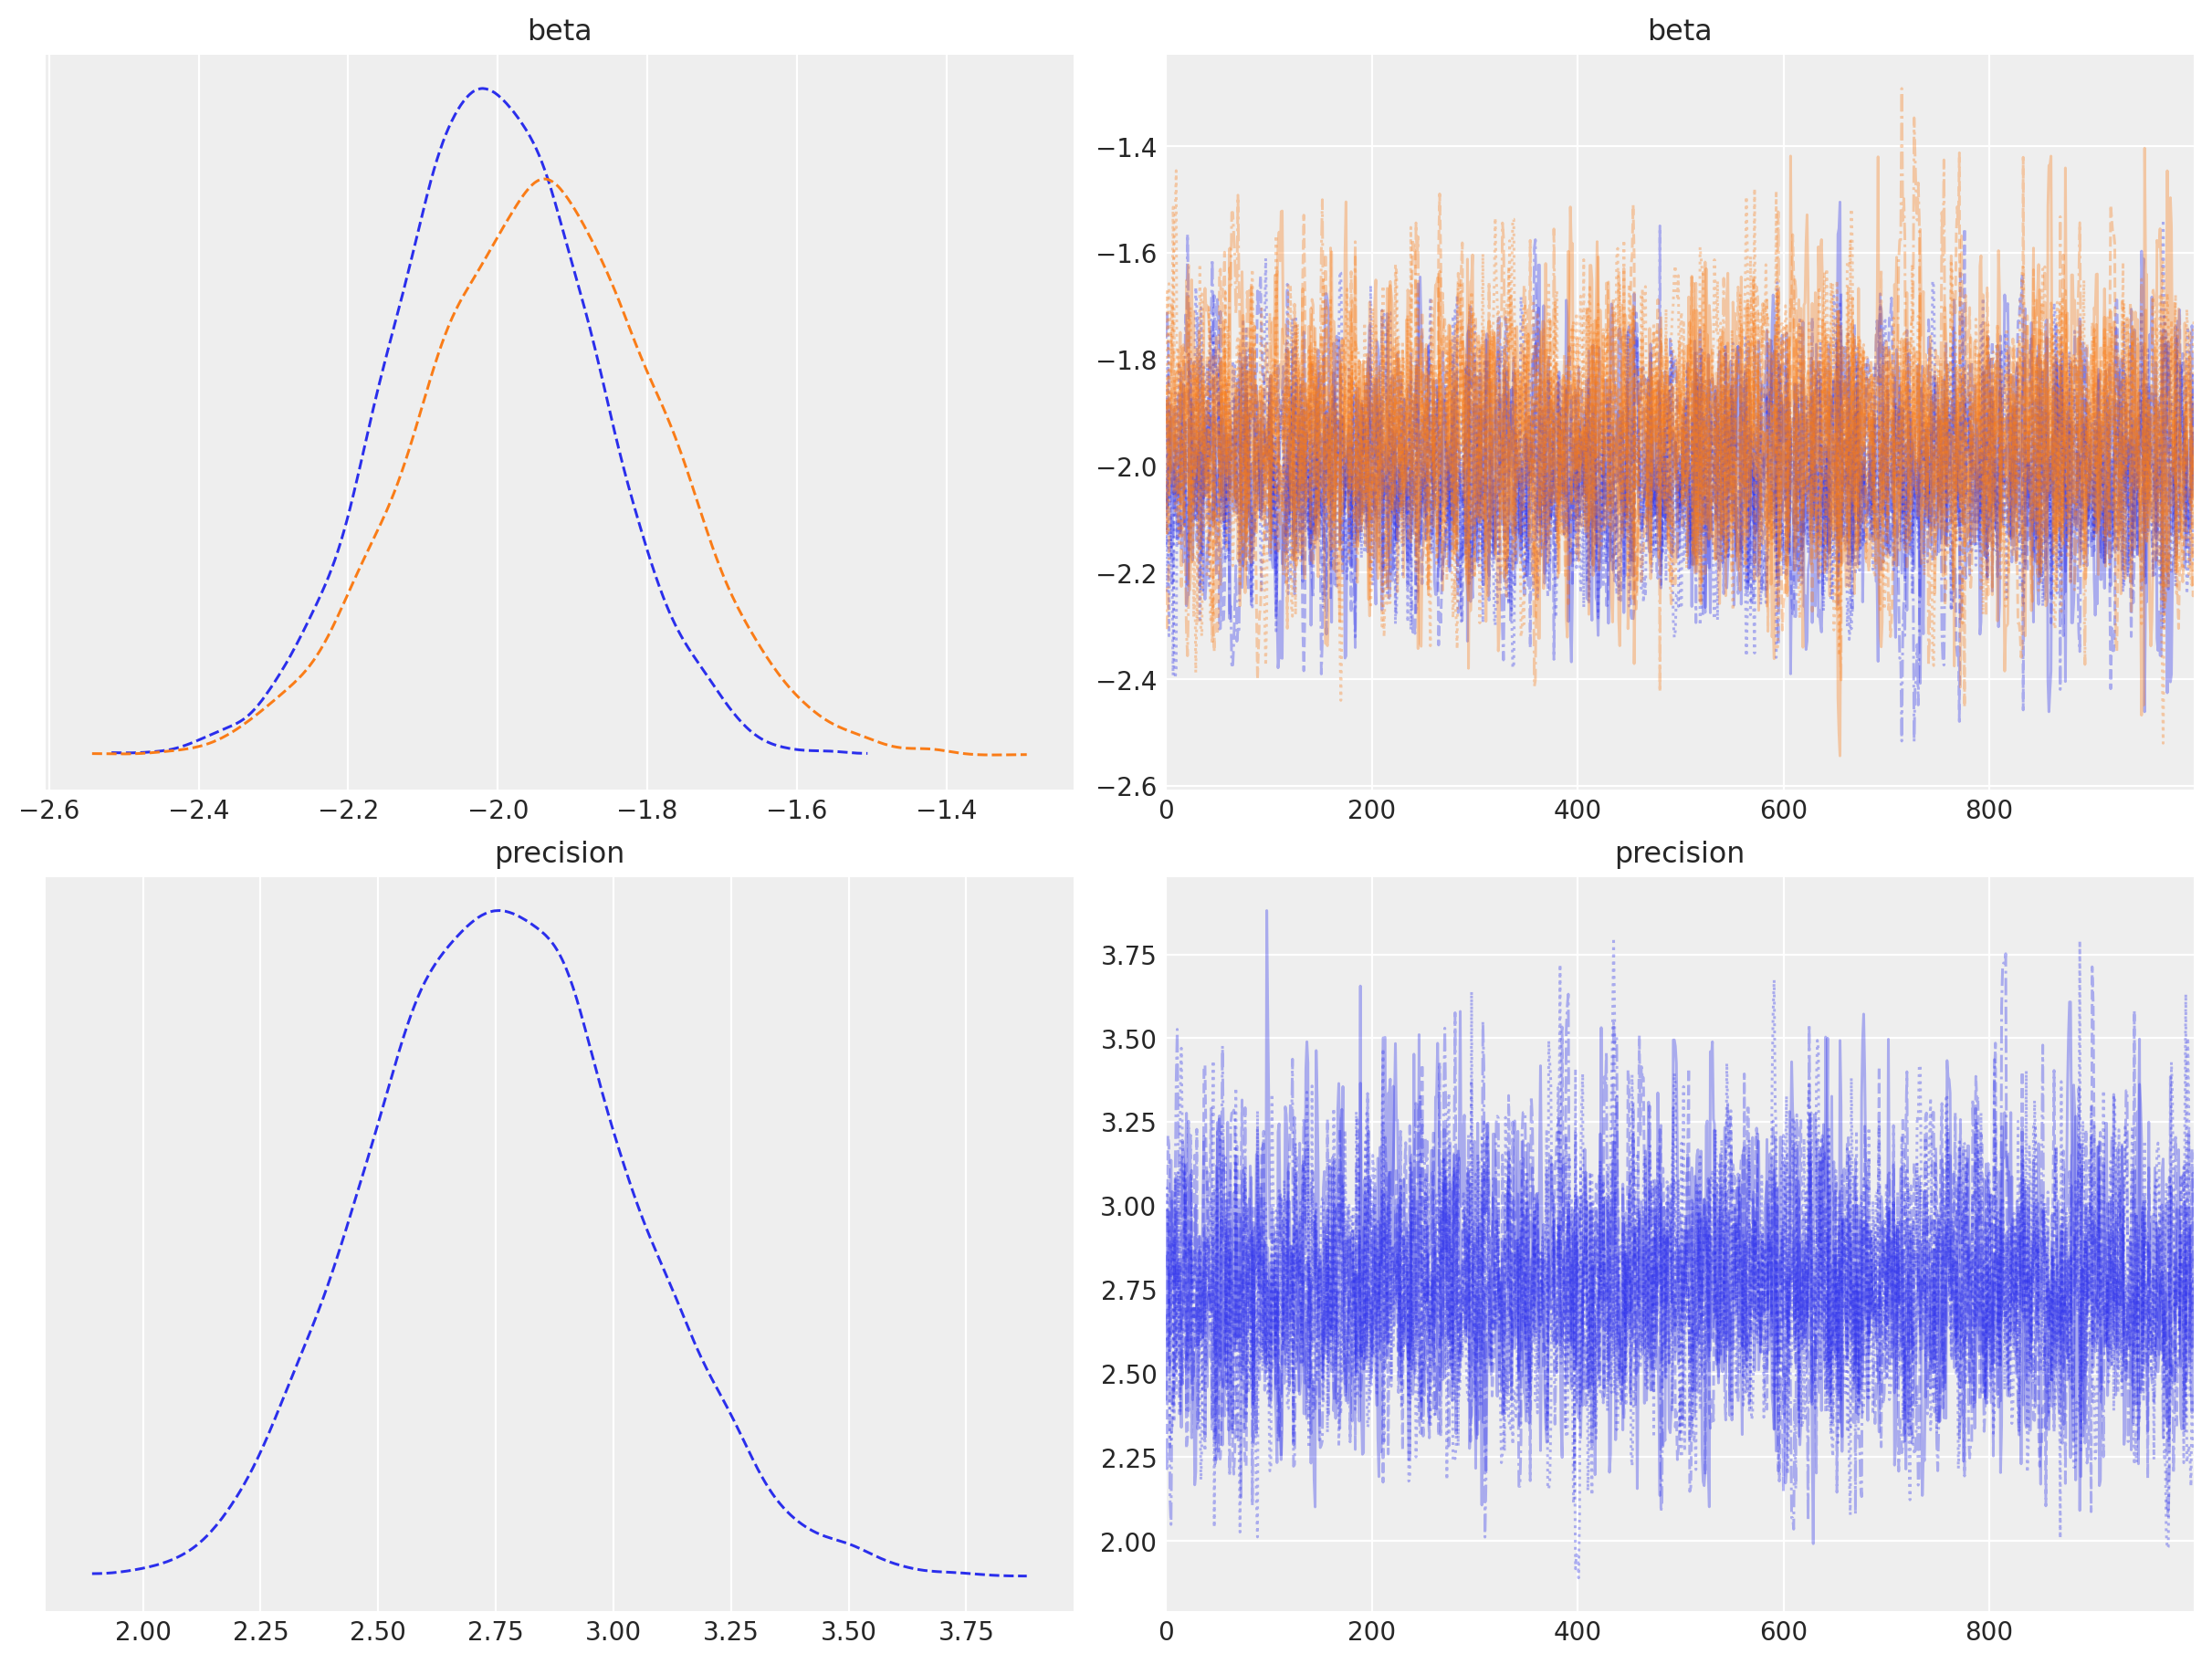

In [29]:
az.plot_trace(trace,combined=True,figsize=(12, 9))

In [30]:
az.summary(trace)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[0]   -2.009  0.136  -2.266   -1.752      0.003    0.002    2277.0   
beta[1]   -1.943  0.161  -2.246   -1.640      0.003    0.002    2323.0   
precision  2.767  0.278   2.256    3.281      0.005    0.004    3025.0   

           ess_tail  r_hat  
beta[0]      2335.0    1.0  
beta[1]      2552.0    1.0  
precision    2907.0    1.0

array([<Axes: title={'center': 'slope'}>,
       <Axes: title={'center': 'intercept'}>,
       <Axes: title={'center': 'error'}>], dtype=object)

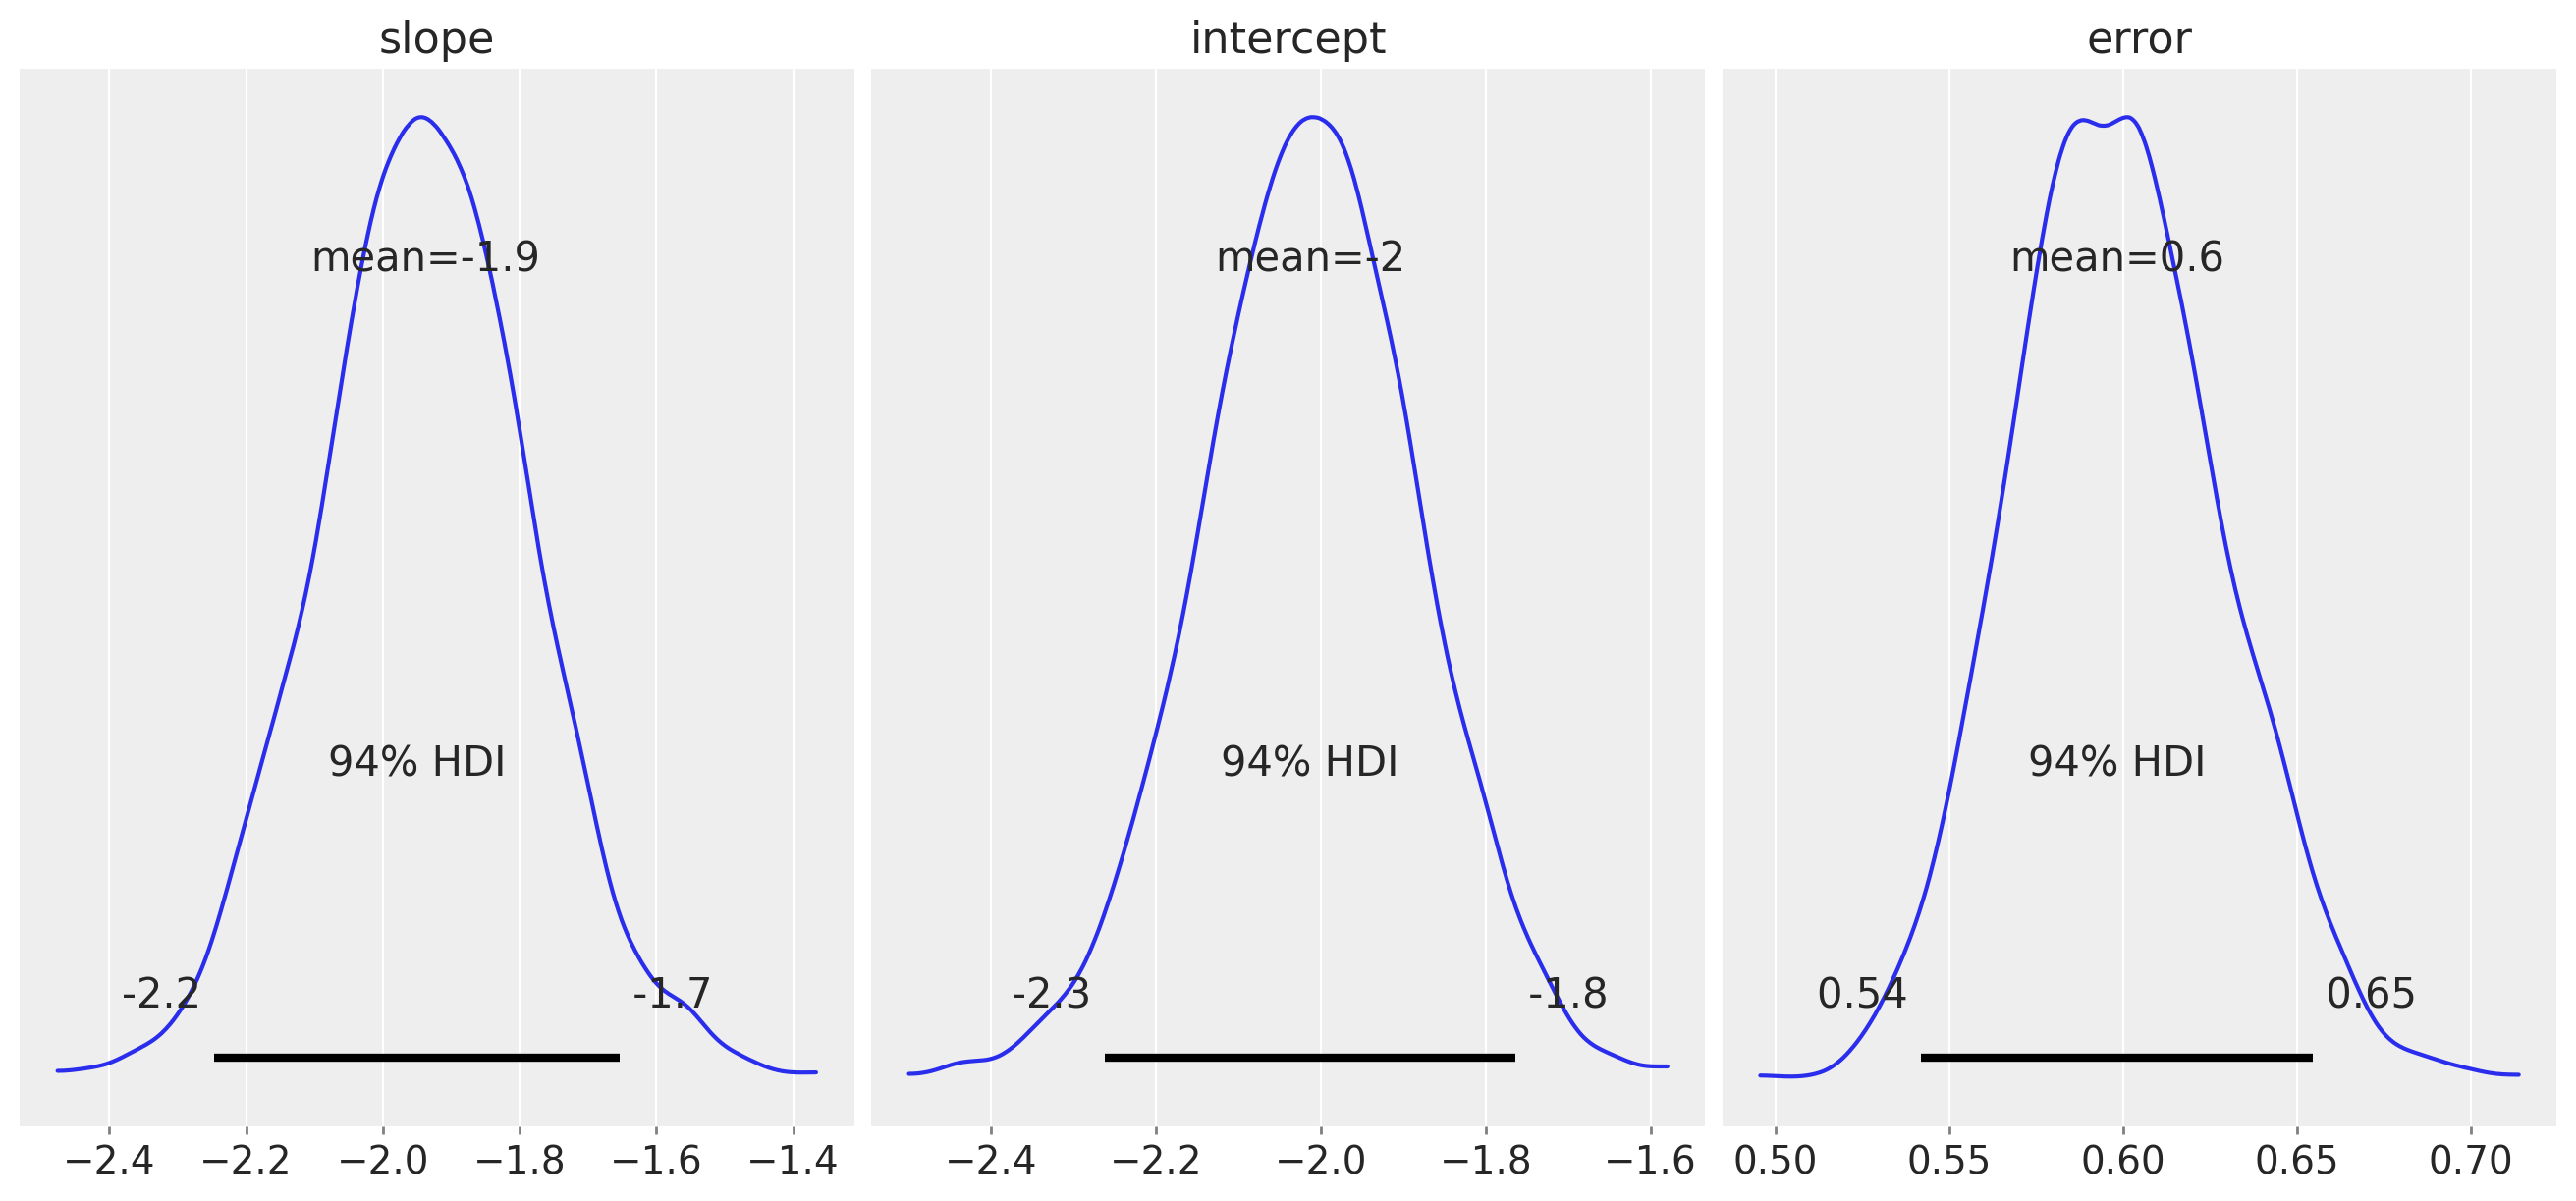

In [50]:
az.plot_posterior(trace,figsize=(13, 6))

In [34]:
#Estimate effective sample size
print(az.ess(trace,var_names=['precision']))

<xarray.Dataset>
Dimensions:    ()
Data variables:
    precision  float64 3.025e+03


array([<Axes: title={'center': 'beta\n0'}>,
       <Axes: title={'center': 'beta\n1'}>], dtype=object)

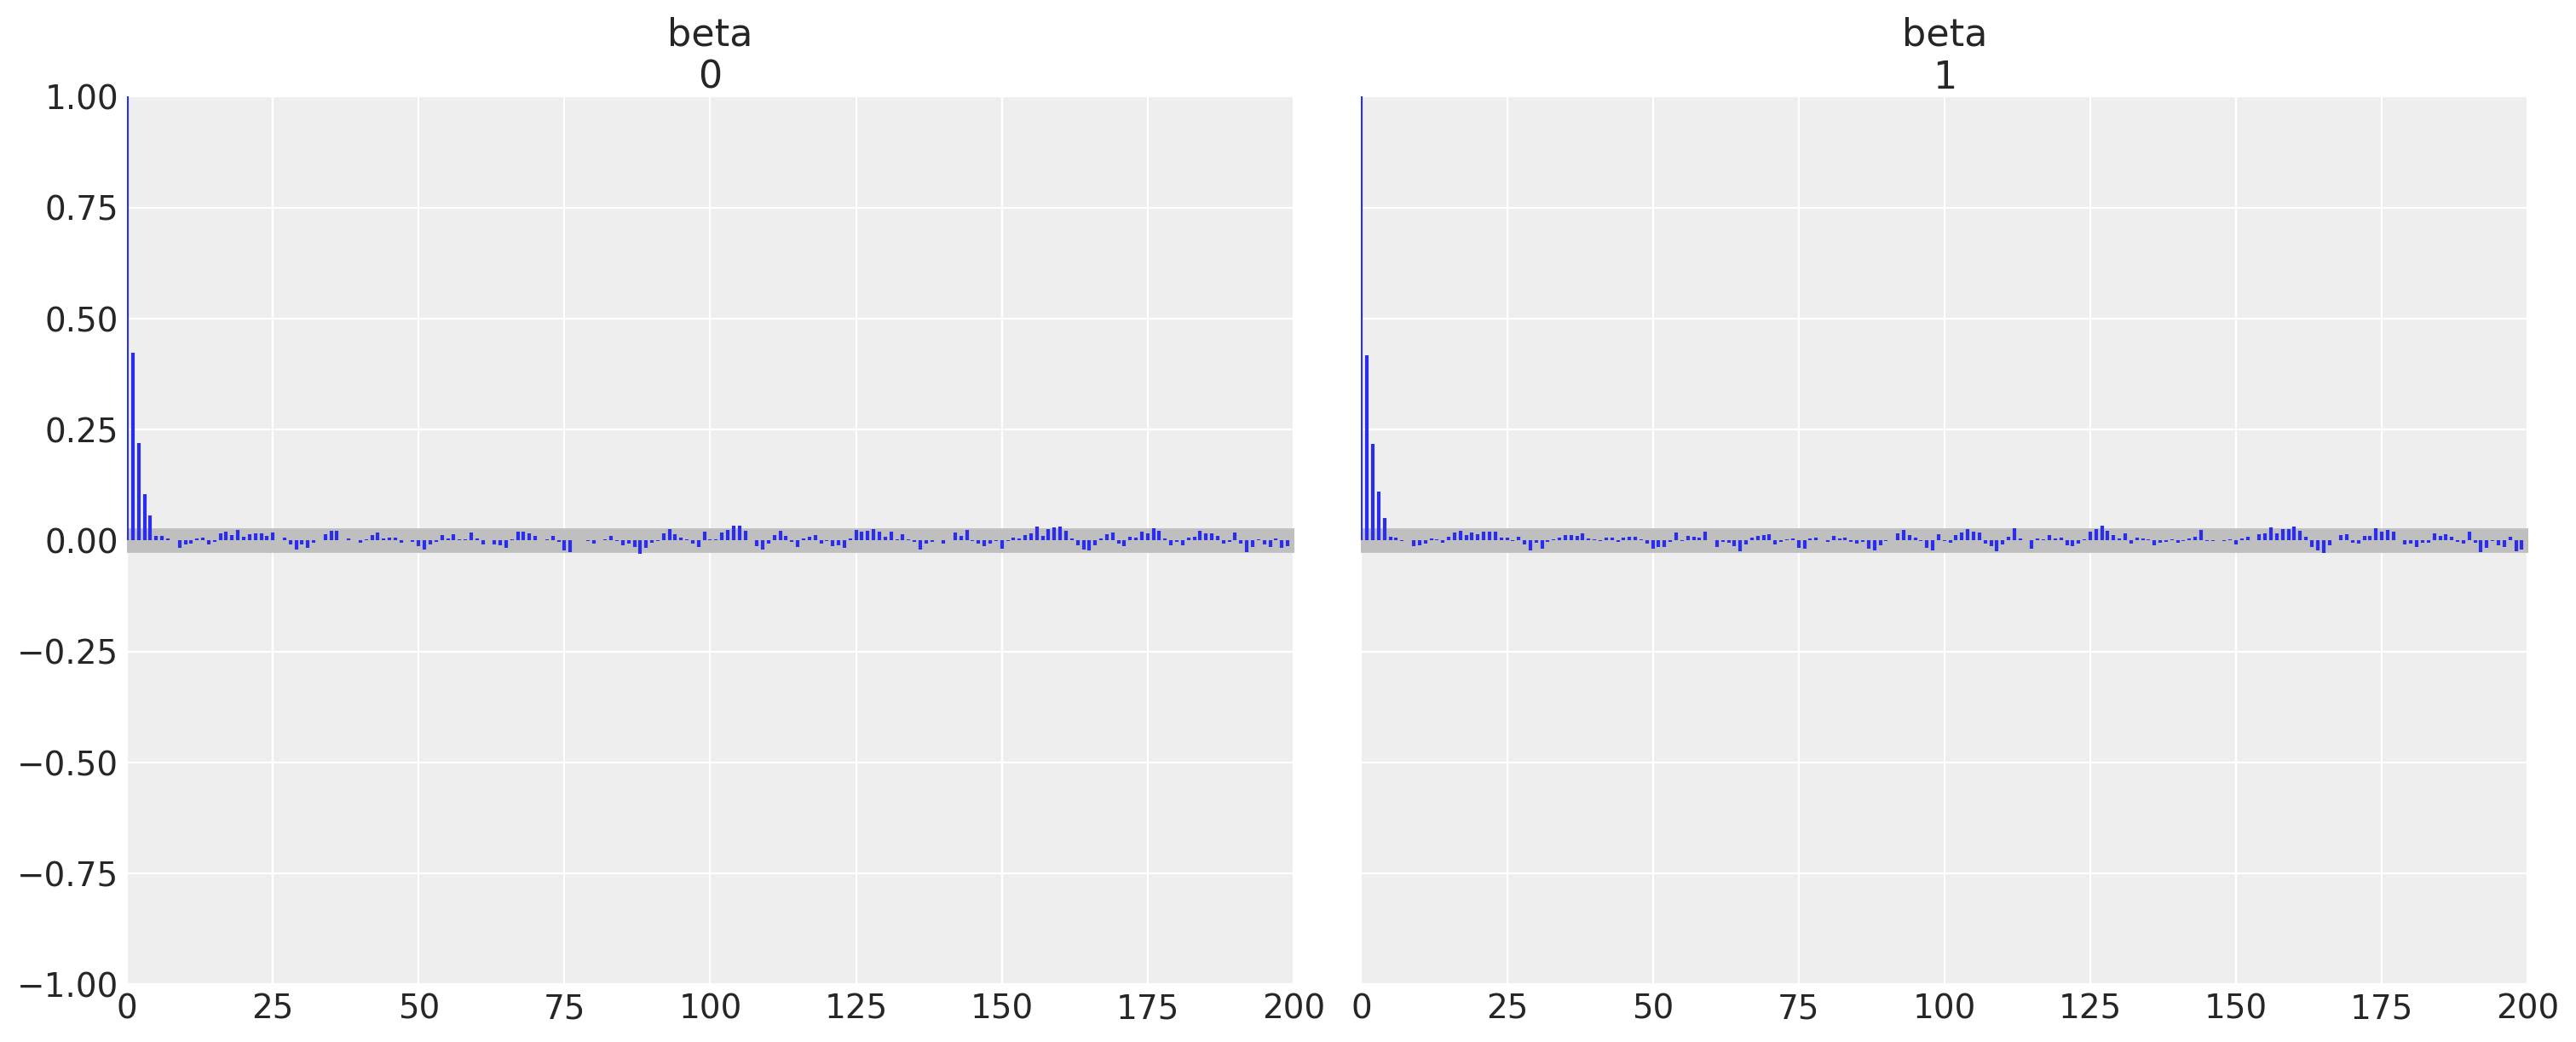

In [35]:
#AUtocorrelation plot

az.plot_autocorr(trace, var_names=['beta'], filter_vars="like",  max_lag=200,combined=True,figsize=(15, 6))



In [36]:
#Posterior predictive sampling

with basic_model:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

trace.posterior_predictive

Sampling: [Y_obs]


<xarray.Dataset>
Dimensions:      (chain: 6, draw: 1000, Y_obs_dim_2: 203)
Coordinates:
  * chain        (chain) int64 0 1 2 3 4 5
  * draw         (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * Y_obs_dim_2  (Y_obs_dim_2) int64 0 1 2 3 4 5 6 ... 197 198 199 200 201 202
Data variables:
    Y_obs        (chain, draw, Y_obs_dim_2) float64 -3.045 -3.713 ... -4.971
Attributes:
    created_at:                 2023-11-01T15:26:02.933048
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.9.0

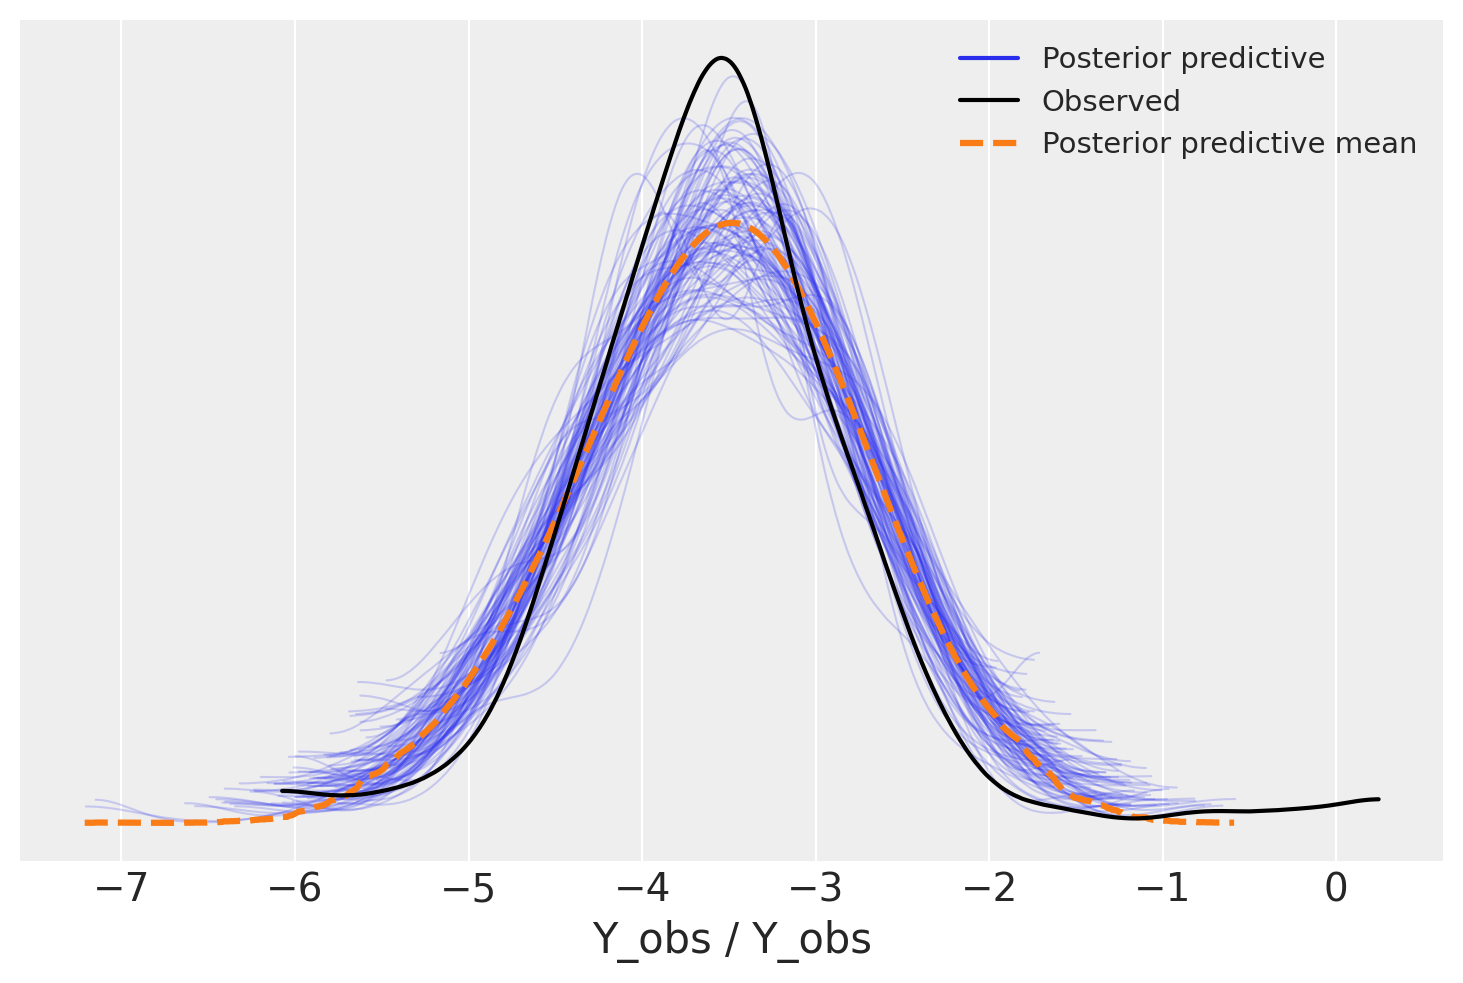

In [37]:
#PLot ppc
az.plot_ppc(trace, num_pp_samples=100);

In [39]:
#Regression?

with pm.Model() as predictive_model:
    a = pm.Normal('slope', 0, 16)
    b = pm.Normal('intercept', 0, 16)
    s = pm.Exponential('error', 1)
    
    x_ = pm.Data('features', x1) # a data container, can be changed
    
    obs = pm.Normal('observation', a*x_ + b, s, observed=y)
    
    trace = pm.sample()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pymc/data.py:433: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, intercept, error]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [49]:
predictive_model


      slope ~ Normal(0, 16)
  intercept ~ Normal(0, 16)
      error ~ Exponential(f())
observation ~ Normal(f(intercept, slope), error)

In [48]:
x_new = np.linspace(-3, 3, 50) # 50 input values between -3 and 3
with predictive_model:
    pm.set_data({'features': x_new})
    posterior = pm.sample_posterior_predictive(trace)

KeyError: 'features'

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [y_sigma, Intercept, x]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


       Formula: y ~ x
        Family: gaussian
          Link: mu = identity
  Observations: 203
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: -3.5596, sigma: 6.1407)
            x ~ Normal(mu: 0.0, sigma: 7.281)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.798)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

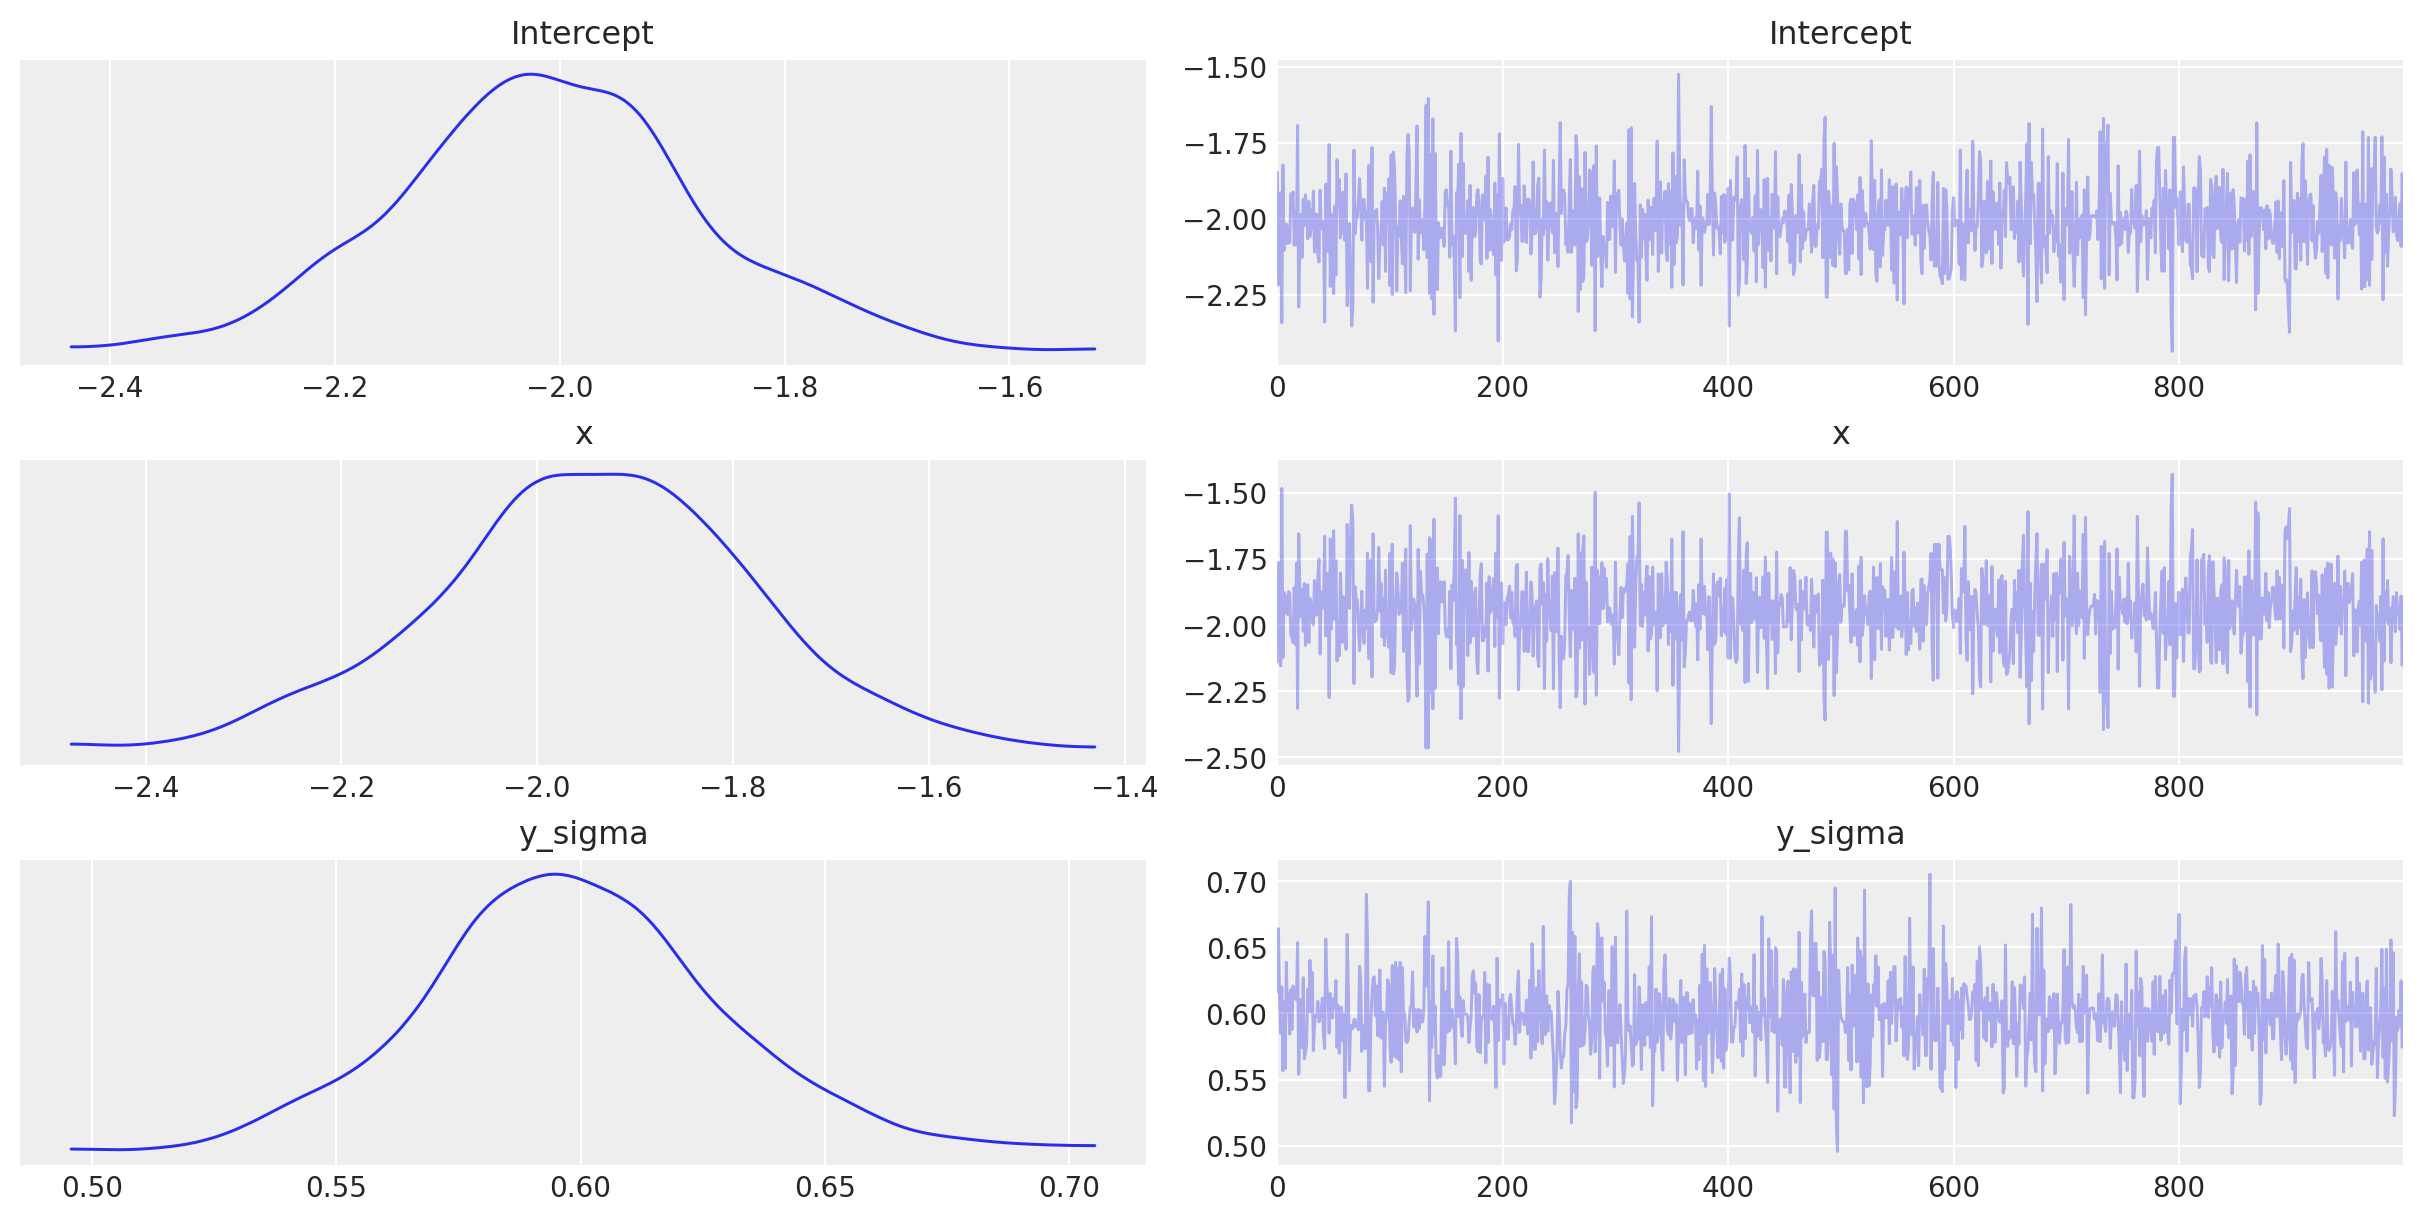

In [51]:
#Using Bambi

import bambi as bmb
import arviz as az
data = pd.DataFrame(dict(x=df['LogP'], y=df['MV']))
model = bmb.Model("y ~ x", data)
idata = model.fit(draws=1000, chains=1)
az.plot_trace(idata)
az.summary(idata)
model 

In [61]:
#Incorporating Measurement Error
ey=0.5
ex=0.5
fx=0.5
fy=0.5
d = 1e-3
b = 1e-3

#Measured values, error on both x and y
x_observed=df['LogP']
y_observed=df['MV']
N=len(x_observed)
tau_x=1/ex**2

with pm.Model() as model:
    # tau_y
    tau_y = Gamma('tau_y', alpha=ey, beta=fy) #Gamma prior for scatter
    
    X1 = Normal("X1", mu=0, tau=b, shape=N) #Normal prior for unknown true predictor
    beta = Normal('beta', mu=0, tau=d, shape=2) #Normal prior on unknown regression coeff
    tau_x = Gamma('tau_x', alpha=ex, beta=fx)
    X_star = Normal('X_star', mu=X1, tau=tau_x, observed=x_observed) #Observed X
    
    Y = Normal("Y", mu=beta[0] + beta[1]*X1, tau=tau_y, observed=y_observed) #MLE as starting point for posterior
    trace = pm.sample(draws=10000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_y, X1, beta, tau_x]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 19 seconds.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.


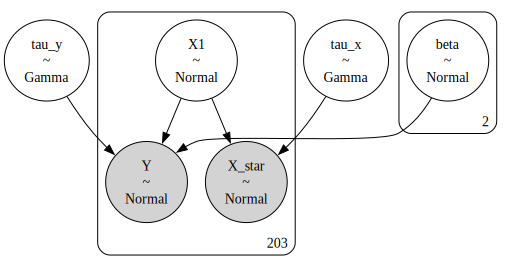

In [62]:
model_to_graphviz(model)


array([[<Axes: title={'center': 'X1'}>, <Axes: title={'center': 'X1'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'tau_y'}>,
        <Axes: title={'center': 'tau_y'}>],
       [<Axes: title={'center': 'tau_x'}>,
        <Axes: title={'center': 'tau_x'}>]], dtype=object)

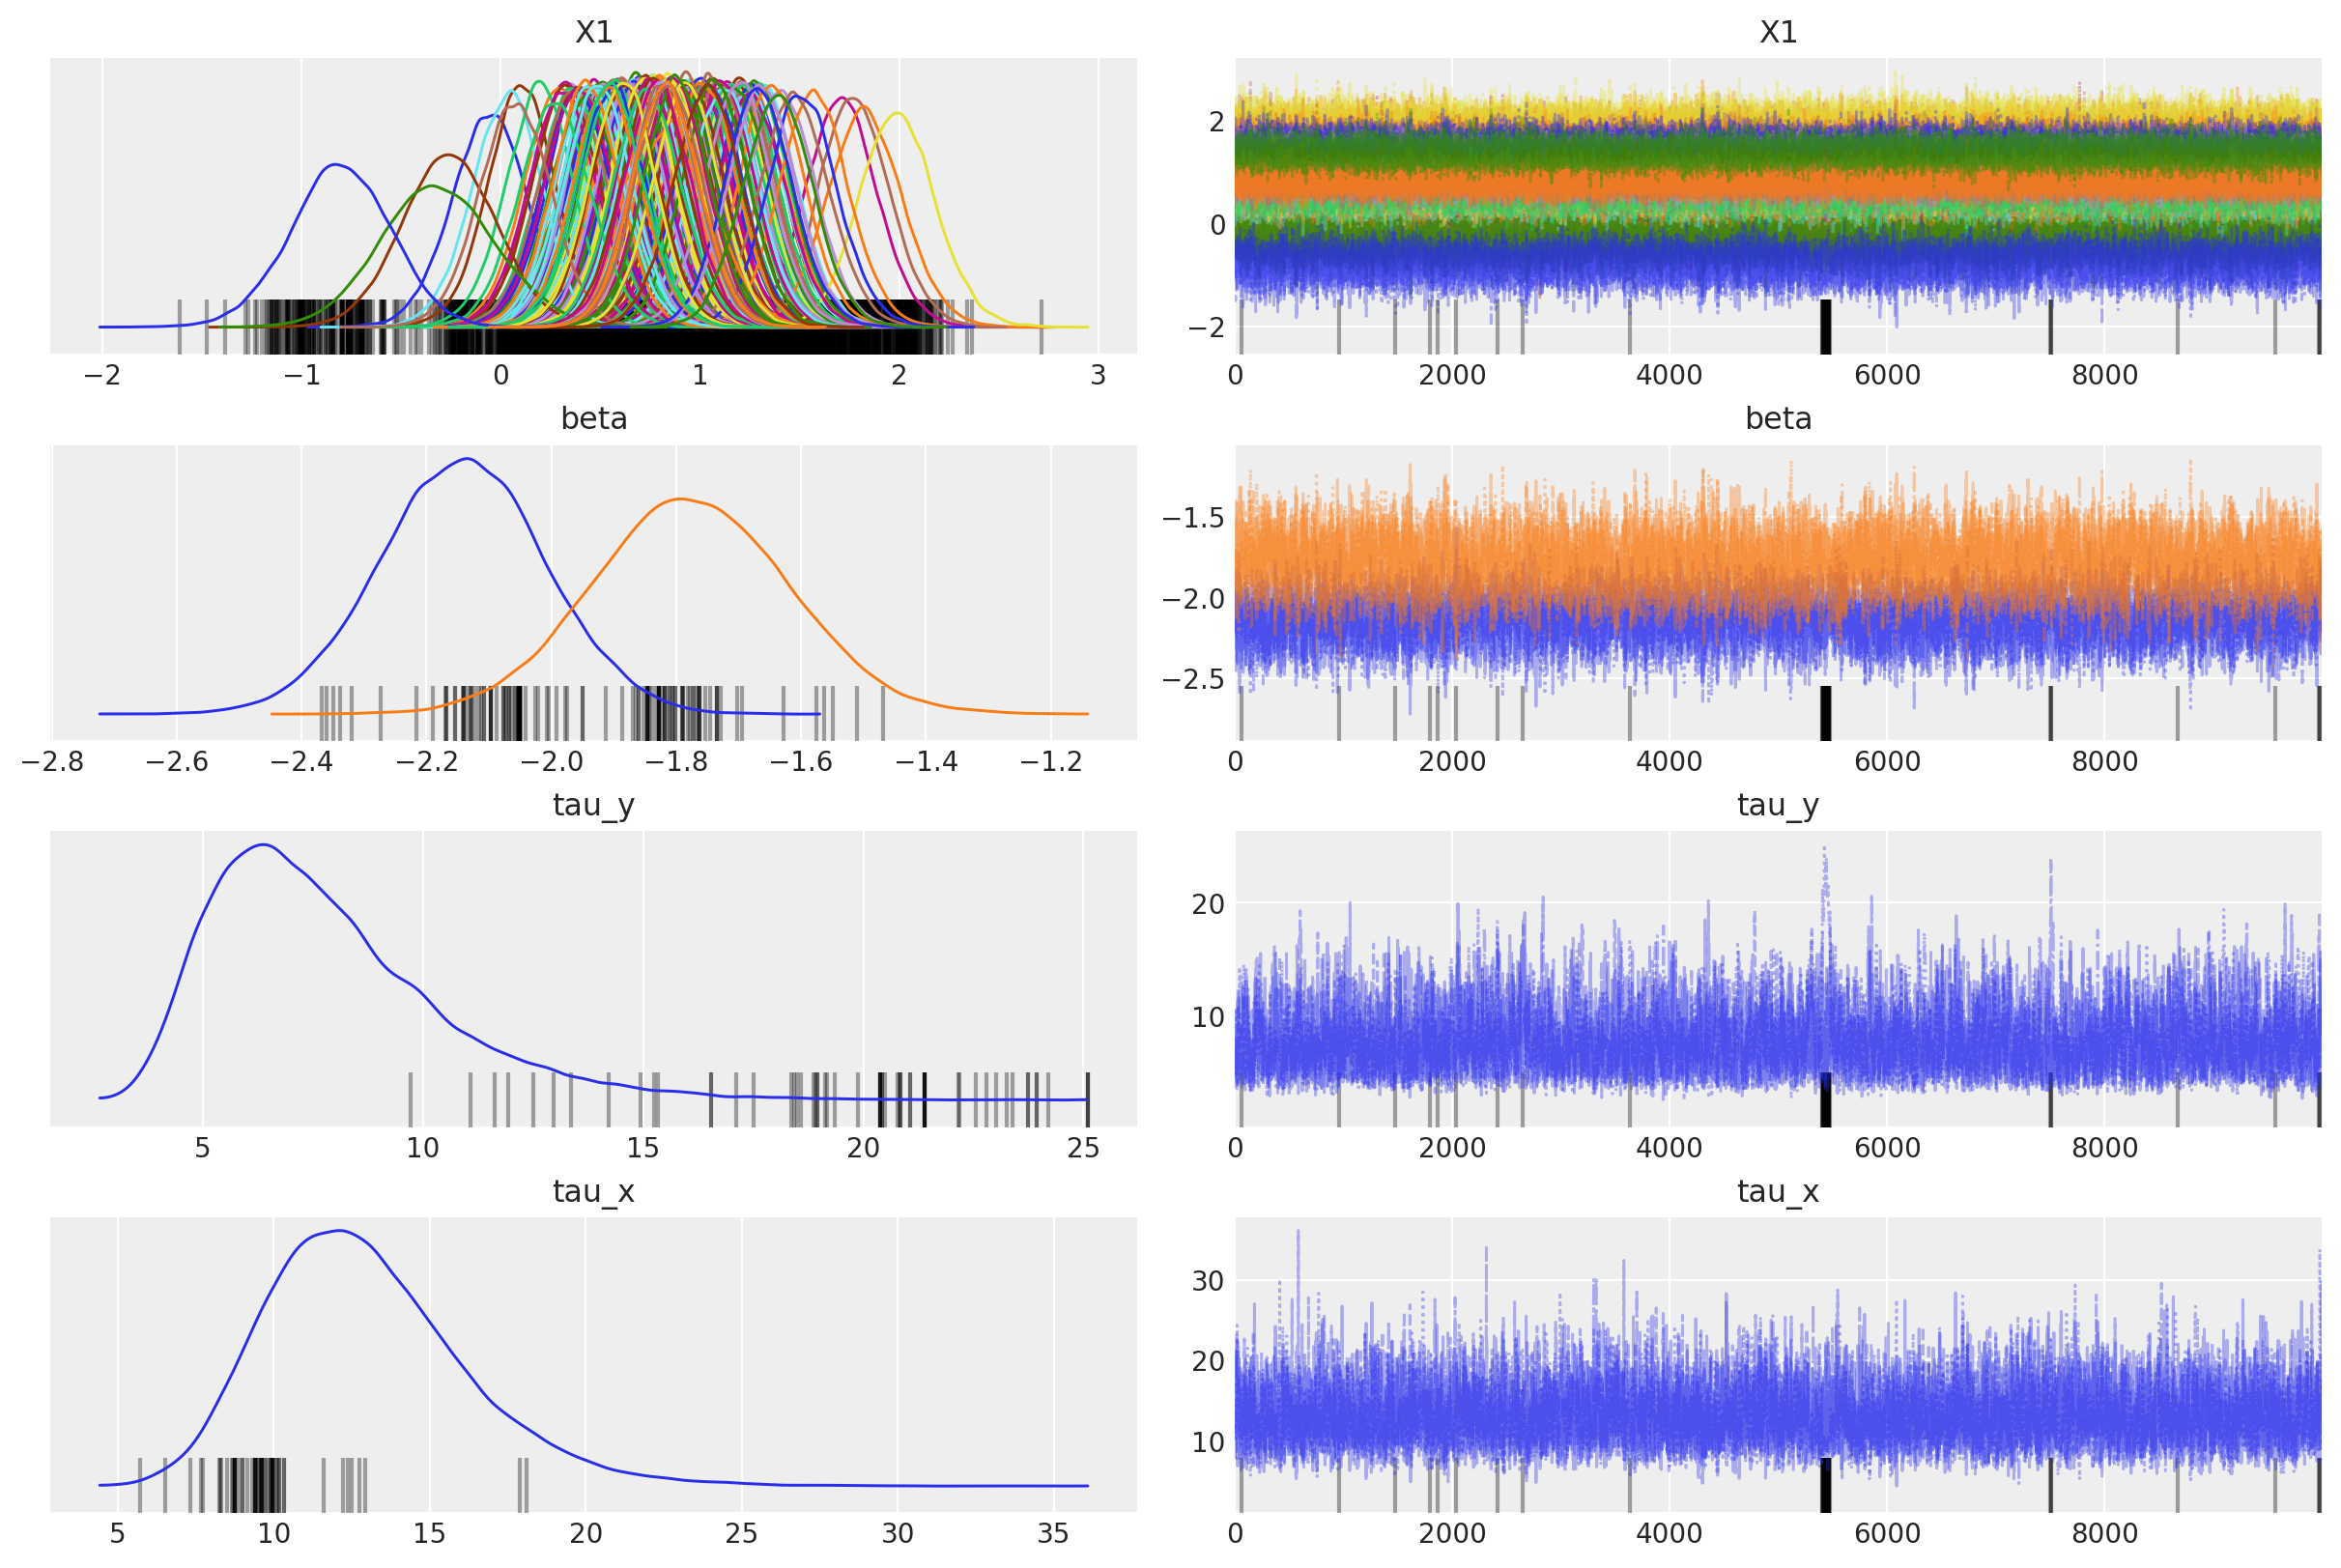

In [63]:
az.plot_trace(trace, combined=True)

In [64]:
az.summary(trace, var_names=['beta','tau_y','tau_x'], round_to=2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta[0]  -2.14  0.13   -2.39    -1.89       0.00     0.00   3779.15   9457.92   
beta[1]  -1.78  0.16   -2.07    -1.49       0.00     0.00   3556.99   8466.16   
tau_y     7.72  2.61    3.65    12.60       0.05     0.04   3155.98   4062.83   
tau_x    12.93  3.22    7.47    19.16       0.04     0.03   5052.52   9657.58   

         r_hat  
beta[0]    1.0  
beta[1]    1.0  
tau_y      1.0  
tau_x      1.0

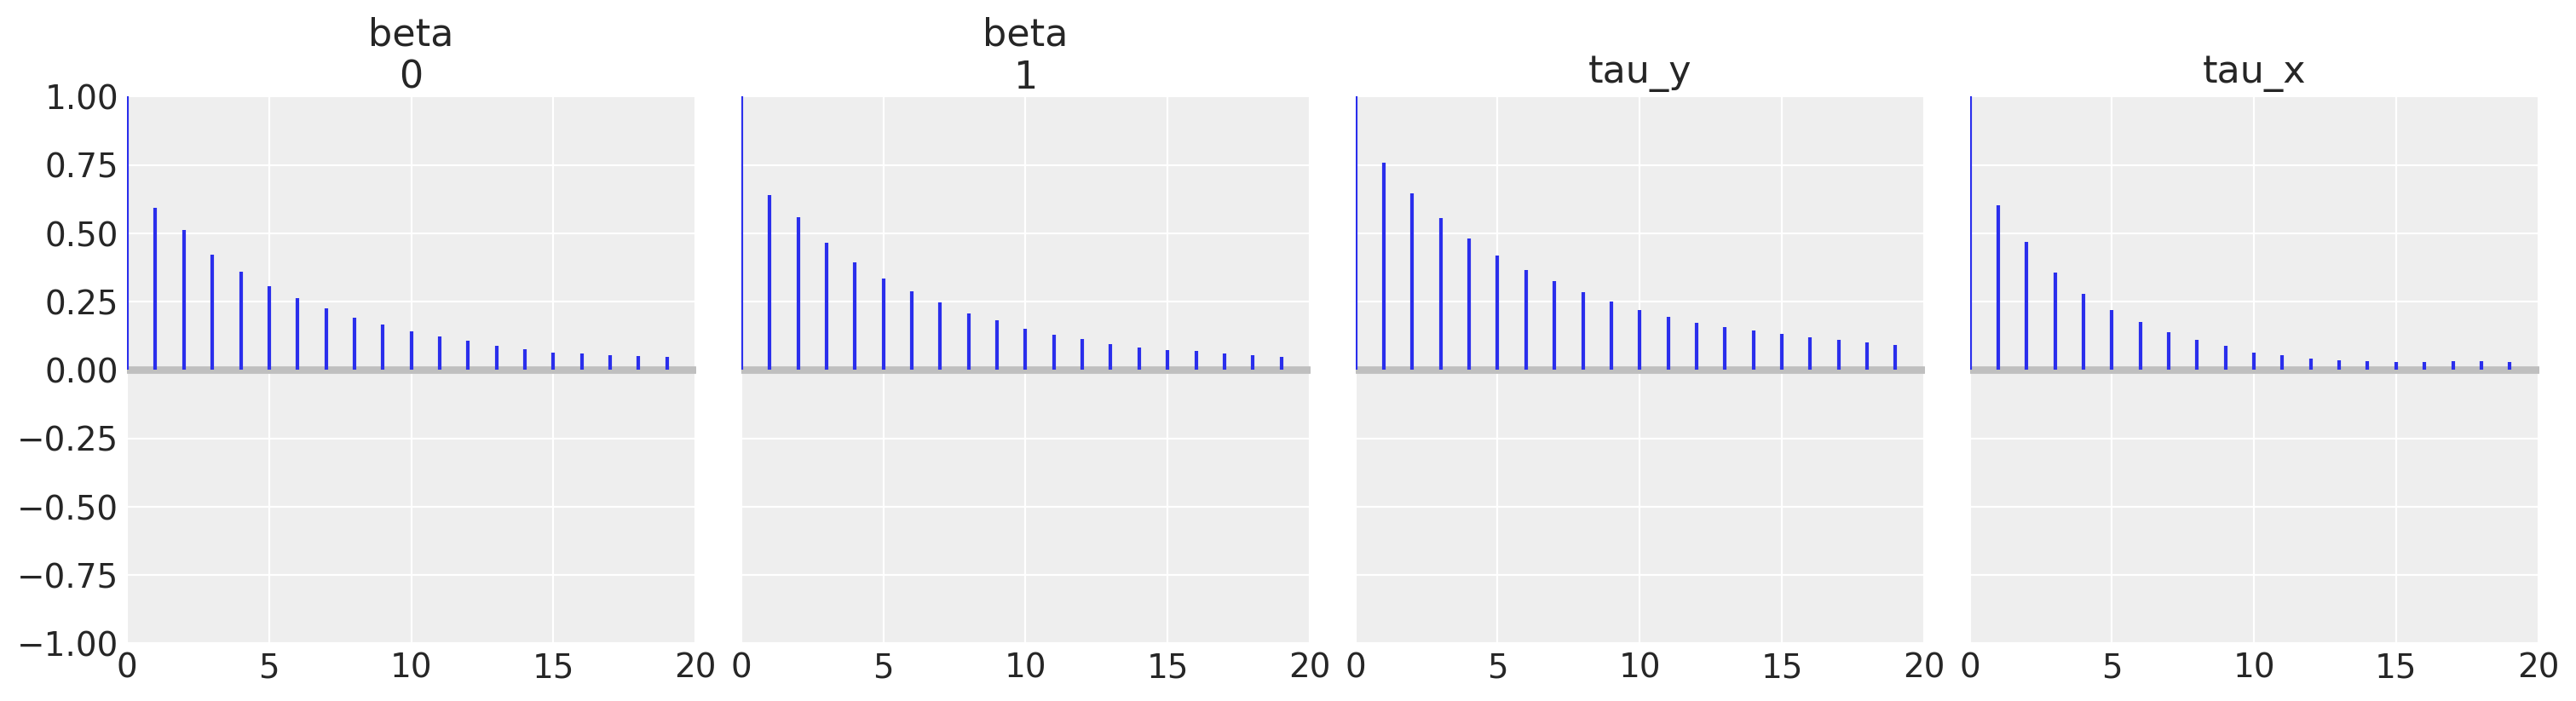

In [67]:
az.plot_autocorr(trace, var_names=['beta','tau_y','tau_x'], filter_vars="like",
max_lag=20,combined=True, figsize=(15, 4))
int_ex=np.array(trace.posterior['beta'][:,:,0].mean())
slope_ex =np.array(trace.posterior['beta'][:,:,1].mean())

NameError: name 'res' is not defined

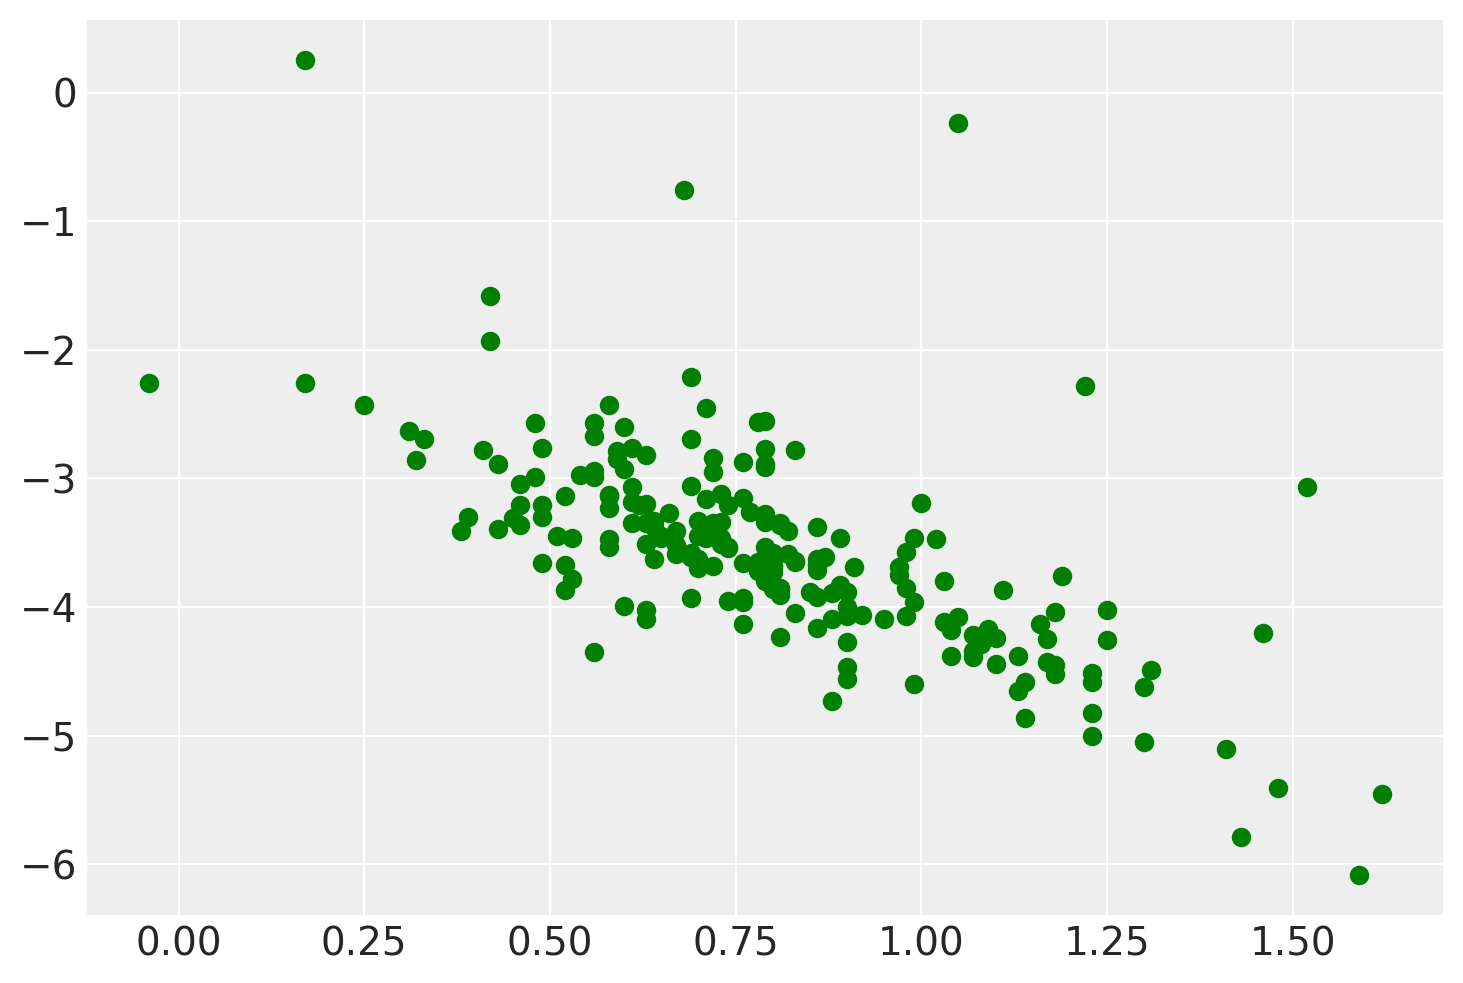

In [71]:
from scipy.stats import linregress
from scipy.stats import t
result = linregress(df['LogP'], y_observed)
#res = linregress(df['LogP'], y_observed+tau_y)
plt.plot(df['LogP'], y_observed, 'o', label='Original data',c='green')
plt.plot(df['LogP'], res.intercept + res.slope*df['LogP'], 'r', label='fitted line MLW\n Bayesian no errors',c='blue')
plt.plot(df['LogP'], int_ex + slope_ex*X_star, label='Bayesian with errors',c='r')
plt.plot(df['LogP'],df['MV'],label='truth',c='orange')
plt.xlabel(r'x$^*$')
plt.ylabel(r'y$^*$')